In [1]:
%pylab inline

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from datetime import datetime
import pandas as pd
import os, glob

pd.options.display.float_format = '{:,.3f}'.format

print("Current directory: %s" % os.getcwd())

Populating the interactive namespace from numpy and matplotlib
Current directory: C:\Users\phtep\Documents\TandemPiercerExperiment\report_template


In [2]:
class Stats():
    
    def __init__(self, headers = None):
        
        self.experiment_directory = "../experiments/*"
        self.statistics_filename = "statistics.csv"
        self.get_experiment_stat_files()
        
        if headers is None:
            self.headers = (
                "Time",
                "Elapsed",
                "A",
                "B",
                "TotA",
                "TotB",
                "RateA",
                "RateB",
                "Cnc",
                "TotCnc",
                "ElapsedCncRate",
                "SampleCncRate",
                "TimeDifference",
                "APulseHeight",
                "BPulseHeight",
                "SampleCncRate_",
                "RateCount",
                "SampleSize",
                "Chn"
            )
        else:
            self.headers = headers

    
    def get_experiment_stat_files(self):
        for experiment_directory in glob.glob(self.experiment_directory):
            statistics_file = os.path.join(experiment_directory, self.statistics_filename)
            if os.path.isfile(statistics_file):
                yield statistics_file
    
    def print_experiment_stat_files(self):
        return list(map(print, self.get_experiment_stat_files()))
    
    def read_stats_dataframe(self, csv_filename):
        self.csv_filename = csv_filename
        df = pd.read_csv(self.csv_filename, sep = ";", names = self.headers)
        self.desc = df.describe()
        df['Time'] = pd.to_datetime(df['Time'], unit = 's')
        self.last_index = len(df) - 1
        self.stats = df
        return self.stats
    
    def get_desc_value(self, col, row):
        return self.desc[col][row]
    
    def sample_size(self):
        return self.get_desc_value("SampleSize", "max")
    
    def max_pulse_height_a(self):
        return self.get_desc_value("APulseHeight", "max")
    def min_pulse_height_a(self):
        return self.get_desc_value("APulseHeight", "min")
    def std_pulse_height_a(self):
        return self.get_desc_value("APulseHeight", "std")
    def mean_pulse_height_a(self):
        return self.get_desc_value("APulseHeight", "mean")
    
    def max_pulse_height_b(self):
        return self.get_desc_value("BPulseHeight", "max")
    def min_pulse_height_b(self):
        return self.get_desc_value("BPulseHeight", "min")
    def std_pulse_height_b(self):
        return self.get_desc_value("BPulseHeight", "std")
    def mean_pulse_height_b(self):
        return self.get_desc_value("BPulseHeight", "mean")

    def pulse_heights_a(self, coincidences = True):
        return self.stats[self.stats["Cnc"] == 1]["APulseHeight"].to_numpy() if coincidences else self.stats["APulseHeight"].to_numpy()
    
    def pulse_heights_b(self, coincidences = True):
        return self.stats[self.stats["Cnc"] == 1]["BPulseHeight"].to_numpy() if coincidences else self.stats["BPulseHeight"].to_numpy()
    
    def time_differences(self, coincidences = True):
        return self.stats[self.stats["Cnc"] == 1]["TimeDifference"].to_numpy() if coincidences else self.stats["TimeDifference"].to_numpy()
    
    def rows_count(self):
        return self.last_index + 1
    
    def rate_a(self):
        return self.get_desc_value("RateA", "max")
    
    def rate_b(self):
        return self.get_desc_value("RateB", "max")
    
    def total_count_a(self):
        return int(self.get_desc_value("TotA", "max"))
    
    def total_count_b(self):
        return int(self.get_desc_value("TotB", "max"))
    
    def total_coincidences(self):
        return int(self.get_desc_value("TotCnc", "max"))
    
    def single_coincidences(self):
        return len(self.stats[self.stats["Cnc"] == 1])
    
    def time_elapsed(self):
        return self.get_desc_value("Elapsed", "max")
    
    def start_time(self):
        return self.stats["Time"][0]
    
    def end_time(self):
        return self.stats["Time"][self.last_index]
    
    def coincidence_elapsed_rate(self):
        return self.get_desc_value("ElapsedCncRate", "max")
    
    def coincidence_sample_rate(self):
        return self.get_desc_value("SampleCncRate", "max")
    
    def info(self):
        return self.stats.info()
    
    def plot(self, cols, *args, **kwargs):
        self.stats[cols].plot(*args, **kwargs)

    def scatter(self, *args, **kwargs):
        self.stats[self.stats["Cnc"] == 1].plot(
            kind = "scatter", 
            x = "APulseHeight",
            y = "BPulseHeight", 
            c = "Chn", 
            colormap = "bwr",
            *args, **kwargs
        )

    def time_difference_histogram(self, *args, **kwargs):
        self.histogram(self.stats[self.stats["Cnc"] == 1]["TimeDifference"], kind = "hist", bins = 128, *args, **kwargs)
    
    def histogram(self, df, *args, **kwargs):
        df.plot(*args, **kwargs)
    
    def spectrum_histogram_a(self, coincidences = True, *args, **kwargs):
        df = self.stats[self.stats["Cnc"] == 1] if coincidences else self.stats
        self.histogram(df["APulseHeight"], kind="hist", bins = 128, *args, **kwargs)
    
    def spectrum_histogram_b(self, coincidences = True, *args, **kwargs):
        df = self.stats[self.stats["Cnc"] == 1] if coincidences else self.stats
        self.histogram(df["BPulseHeight"], kind = "hist", bins = 128, *args, **kwargs)
    
    def plot_channel_counts(self):
        fig, ax = plt.subplots()
        for axis in [ax.xaxis, ax.yaxis]:
            axis.set_major_locator(ticker.MaxNLocator(integer=True))
        self.plot(["A", "B"], kind = "line", figsize = (12,4), ax = ax)
    
    def plot_channel_totals_and_rates(self):
        fig, axes = plt.subplots(nrows=2, ncols=1)
        self.plot(["TotA", "TotB"], figsize = (12,6), ax = axes[0])
        self.plot(["RateA", "RateB"], figsize = (12,6), ax = axes[1])
        
    def plot_coincidences_and_sample_size(self):
        fig, axes = plt.subplots(nrows = 1, ncols = 3)
        self.plot(["Cnc", "TotCnc"], figsize = (18, 4), ax = axes[0])
        self.plot(["SampleCncRate", "ElapsedCncRate"], figsize = (18, 4), ax = axes[1])
        self.plot(["SampleSize", "Chn"], figsize = (18, 4), ax = axes[2])
    
    def plot_time_histogram_and_scatter(self):
        fig, axes = plt.subplots(nrows = 1, ncols = 2)
        for axis in [axes[0].xaxis, axes[0].yaxis]:
            axis.set_major_locator(ticker.MaxNLocator(integer = True))
        self.time_difference_histogram(figsize = (12, 4), ax = axes[0])
        self.scatter(figsize = (12, 4), ax = axes[1])
        
    def plot_spectra(self):
        fig, axes = plt.subplots(nrows = 1, ncols = 2)
        for ax in axes:
            for axis in [ax.xaxis, ax.yaxis]:
                axis.set_major_locator(ticker.MaxNLocator(integer = True))
        self.spectrum_histogram_a(figsize = (12, 4), ax = axes[0], color = "red");
        self.spectrum_histogram_b(figsize = (12, 4), ax = axes[1]);
    

In [3]:
st = Stats()
st.print_experiment_stat_files();

../experiments\default_2022_2_10_21_15\statistics.csv
../experiments\default_2022_2_10_21_19\statistics.csv
../experiments\default_2022_2_10_21_22\statistics.csv
../experiments\default_2022_2_10_21_34\statistics.csv
../experiments\default_2022_2_10_21_7\statistics.csv
../experiments\default_2022_2_10_21_8\statistics.csv


In [4]:
st.read_stats_dataframe("../experiments\default_2022_2_10_21_34\statistics.csv").describe()

,Elapsed,A,B,TotA,TotB,RateA,RateB,Cnc,TotCnc,ElapsedCncRate,SampleCncRate,TimeDifference,APulseHeight,BPulseHeight,SampleCncRate_,RateCount,SampleSize,Chn
count,"6,394.000","6,394.000","6,394.000","6,394.000","6,394.000","6,394.000","6,394.000","6,394.000","6,394.000","6,394.000","6,394.000","6,394.000","6,394.000","6,394.000","6,394.000","6,394.000","6,394.000","6,394.000"
mean,99.284,0.051,0.046,79.171,81.587,8.593,9.100,0.002,4.790,0.036,0.386,1.221,5.780,9.469,0.386,"1,599.000",9.364,0.500
std,57.303,0.227,0.218,42.487,42.749,1.183,1.142,0.050,3.999,0.023,0.240,91.636,152.624,295.767,0.240,922.967,5.405,0.500
min,0.047,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,"-4,395.000",0.000,0.000,0.000,1.000,0.006,0.000
25%,49.684,0.000,0.000,42.000,48.000,8.107,8.396,0.000,1.000,0.020,0.212,0.000,0.000,0.000,0.212,800.000,4.685,0.000
50%,99.298,0.000,0.000,84.000,83.000,8.675,8.954,0.000,3.000,0.033,0.353,0.000,0.000,0.000,0.353,"1,599.000",9.364,0.500
75%,148.883,0.000,0.000,113.000,118.000,9.167,9.783,0.000,8.000,0.058,0.612,0.000,0.000,0.000,0.612,"2,398.000",14.043,1.000
max,198.547,2.000,2.000,152.000,147.000,28.461,24.395,2.000,12.000,0.066,0.699,"3,800.000","5,903.000","14,880.000",0.699,"3,197.000",18.722,1.000


In [5]:
st.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6394 entries, 0 to 6393
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Time            6394 non-null   datetime64[ns]
 1   Elapsed         6394 non-null   float64       
 2   A               6394 non-null   int64         
 3   B               6394 non-null   int64         
 4   TotA            6394 non-null   int64         
 5   TotB            6394 non-null   int64         
 6   RateA           6394 non-null   float64       
 7   RateB           6394 non-null   float64       
 8   Cnc             6394 non-null   int64         
 9   TotCnc          6394 non-null   int64         
 10  ElapsedCncRate  6394 non-null   float64       
 11  SampleCncRate   6394 non-null   float64       
 12  TimeDifference  6394 non-null   int64         
 13  APulseHeight    6394 non-null   int64         
 14  BPulseHeight    6394 non-null   int64         
 15  Samp

In [6]:
[
    "Max pulse height A: %s" % st.max_pulse_height_a(), 
    "Max pulse height B: %s" % st.max_pulse_height_b(),
    "Min pulse height A: %s" % st.min_pulse_height_a(), 
    "Min pulse height B: %s" % st.min_pulse_height_b(), 
    "Std pulse height A: %s" % st.std_pulse_height_a(), 
    "Std pulse height B: %s" % st.std_pulse_height_b(), 
    "Mean pulse height A: %s" % st.mean_pulse_height_a(),
    "Mean pulse height B: %s" % st.mean_pulse_height_b()
]

['Max pulse height A: 5903.0',
 'Max pulse height B: 14880.0',
 'Min pulse height A: 0.0',
 'Min pulse height B: 0.0',
 'Std pulse height A: 152.62375557687935',
 'Std pulse height B: 295.7668386852374',
 'Mean pulse height A: 5.780106349702846',
 'Mean pulse height B: 9.468564279011574']

In [7]:
[
    "rows_count %s" % st.rows_count(),
    
    "rate_a %s" % st.rate_a(),
    
    "rate_b %s" % st.rate_b(),
    
    "total_count_a %s" % st.total_count_a(),
    
    "total_count_b %s" % st.total_count_b(),
    
    "total_coincidences %s" % st.total_coincidences(),
    
    "single_coincidences %s" % st.single_coincidences(),
    
    "time_elapsed %s" % st.time_elapsed(),
    
    "start_time %s" % st.start_time(),
    
    "end_time %s" % st.end_time(),
    
    "coincidence_elapsed_rate %s" % st.coincidence_elapsed_rate(),
    
    "coincidence_sample_rate %s" % st.coincidence_sample_rate()
]

['rows_count 6394',
 'rate_a 28.460837887067395',
 'rate_b 24.395003903200628',
 'total_count_a 152',
 'total_count_b 147',
 'total_coincidences 12',
 'single_coincidences 8',
 'time_elapsed 198.5469186306',
 'start_time 2022-02-10 19:34:10.047165155',
 'end_time 2022-02-10 19:37:28.547173262',
 'coincidence_elapsed_rate 0.06591563561032805',
 'coincidence_sample_rate 0.6989018853577259']

In [8]:
[
    st.pulse_heights_a(),
    st.pulse_heights_b(),
    st.time_differences()
]

[array([3593, 2566, 3080, 3593, 4363, 4620, 2310, 5903], dtype=int64),
 array([ 3591,  5900,  4617,  2052,  9492,   256, 12058,  3848],
       dtype=int64),
 array([ 1052,     0,  3800, -4395,  2659,     0,  2159,  -473],
       dtype=int64)]

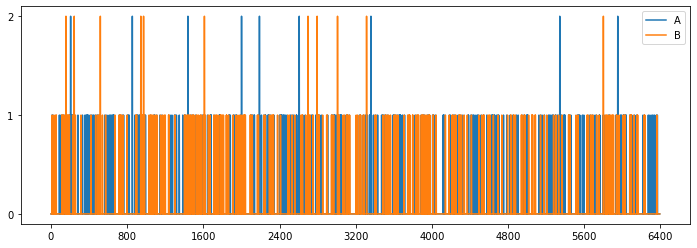

In [9]:
st.plot_channel_counts()

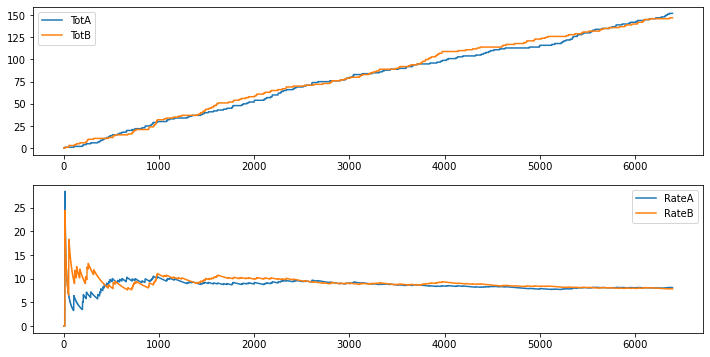

In [10]:
st.plot_channel_totals_and_rates()

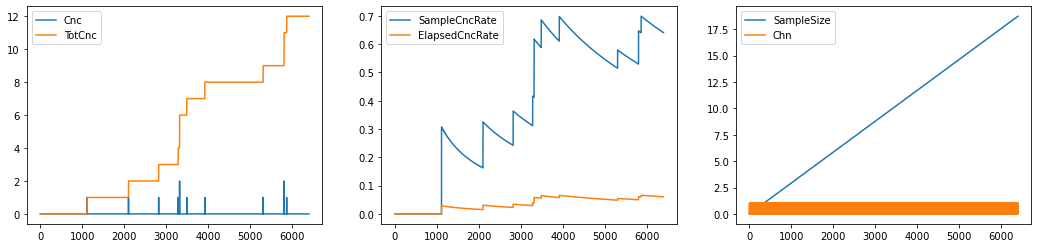

In [11]:
st.plot_coincidences_and_sample_size()

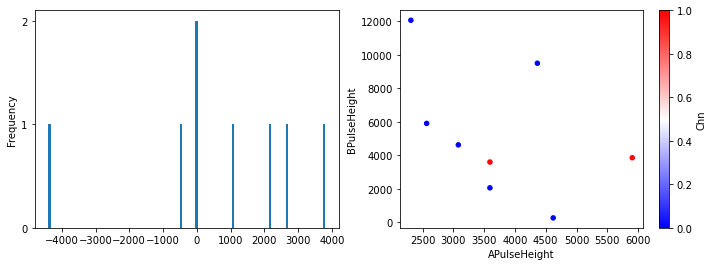

In [12]:
st.plot_time_histogram_and_scatter()

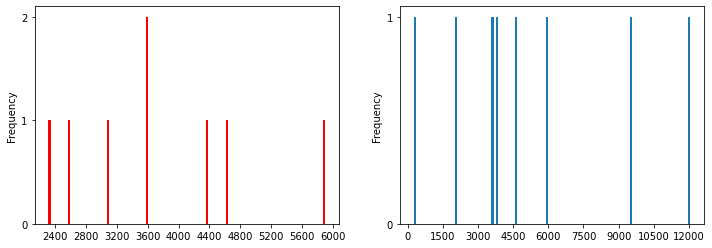

In [13]:
st.plot_spectra()